# Time / precision 3D

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans le TestCase1 3D.

On cherche à obtenir le temps et l'erreur de FEM pour différents $N$.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import time
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.despine(left=True)
import dataframe_image as dfi

from modfenics.solver_fem.solver_fem_1_3D import FEMSolver
from testcases.utils import create_tree

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


<Figure size 640x480 with 0 Axes>

In [4]:
if testcase == 1:
    from testcases.problem.problem_3D import TestCase1_3D
    problem = TestCase1_3D()
else:
    raise ValueError("Testcase not found")

result_dir = "../../results/fenics/test_3D/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/time_precision/"
create_tree(result_dir)

In [5]:
def get_param(i):
    params = problem.parameter_domain
    # params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1]), np.random.uniform(params[2][0], params[2][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22 0.1 ]


## Convergence FEM

In [6]:
# import vedo
# vedo.settings.default_backend= 'vtk'
# vedo.Cone().show(axes=1).close()

In [12]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    tab_times_FEM = list(df_FEM['times'].values)
    tab_subtimes_FEM = {}
    for key in df_FEM.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_FEM[key] = list(df_FEM[key].values)
    
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [20,40,80,90,100]
        tab_h_FEM = []
        tab_err_FEM = []
        tab_times_FEM = []
        tab_subtimes_FEM = {}

        iter_solver = False
        for nb_vert in tab_nb_vert_FEM:
            if nb_vert>=50:
                iter_solver=True
                
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=3)
            
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0,iter_solver=iter_solver)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            
            # from vedo.dolfin import plot as vplot
            # vplot(sol, cmap='viridis', add=True, wireframe=True)
            
            tab_err_FEM.append(norme_L2)
            times_FEM = solver.times_fem
            for key in times_FEM:
                if key in tab_subtimes_FEM:
                    tab_subtimes_FEM[key].append(times_FEM[key])
                else:
                    tab_subtimes_FEM[key] = [times_FEM[key]]
            total = sum(times_FEM.values())
            print(f"total time: {total}")
            tab_times_FEM.append(total)
        
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM, 'times': tab_times_FEM, **tab_subtimes_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

In [13]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = run_FEM(degree,new_run=True)

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 640x480 with 0 Axes>

## Plots

In [9]:
print("subtimes FEM : ", tab_subtimes_FEM)
print("times FEM : ", tab_times_FEM)

subtimes FEM :  {'mesh': [0.0042357444763183, 0.0142135620117187, 0.1246802806854248, 0.1927952766418457, 0.2445631027221679], 'assemble': [50.284212827682495, 442.29187631607056, 3673.089465141296, 5195.495839357376, 7211.197880983353], 'solve': [0.2849161624908447, 4.993787050247192, 4.735661506652832, 6.759082317352295, 9.842759370803831]}
times FEM :  [50.57336473464966, 447.2998769283295, 3677.949806928634, 5202.44771695137, 7221.285203456879]


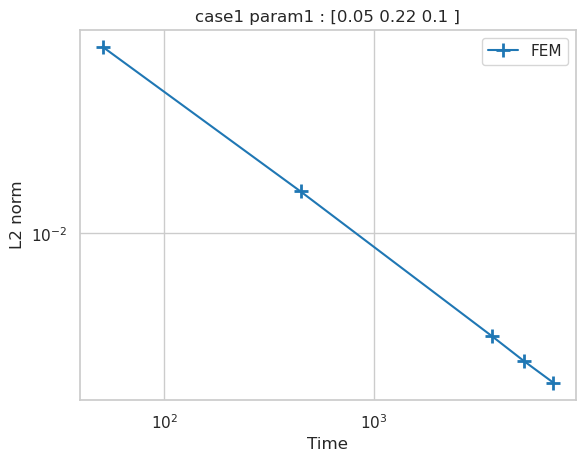

In [10]:
colors = ["tab:blue","tab:red","tab:cyan","tab:orange"]

plt.figure()

def plot_values(times,norms,color,label):
    plt.loglog(times,norms,"+-",color=color,label=label,markersize=10,markeredgewidth=2)

plot_values(tab_times_FEM,tab_err_FEM,colors[0],"FEM")

plt.xlabel("Time")
plt.ylabel("L2 norm")

plt.legend()
plt.title(f'case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f"time_precision_param{param_num}_degree{degree}.png")

In [11]:
tab_times_FEM_ = np.round(tab_times_FEM, 0)
tab_times_FEM_ = tab_times_FEM_.astype(int)

# create string with ..h..min..s (if needed)

tab_times_FEM_str = []
for time in tab_times_FEM_:
    time_str = ""
    if time >= 3600:
        time_str += str(time//3600) + "h"
        time = time % 3600
    if time >= 60:
        time_str += str(time//60) + "min"
        time = time % 60
    if time > 0:
        time_str += str(time) + "s"
    tab_times_FEM_str.append(time_str)

In [12]:
df_time_pres = pd.DataFrame(np.array([tab_err_FEM,tab_times_FEM_str]).T,columns=["err","CPU times"],index=tab_nb_vert_FEM)
df_time_pres

,err,CPU times
20,0.0610268155205595,51s
40,0.0150110961335434,7min27s
80,0.0036898010457549,1h1min18s
90,0.0029089212852329,1h26min42s
100,0.0023519239014755,2h21s
